In [19]:
import matplotlib.pyplot as plt
import torchvision
from torchvision.io import read_image
import os
import torch
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as T
import torch.utils as utils
from torchvision.utils import draw_segmentation_masks
import numpy as np
from PIL import Image

In [20]:
def read_image_as_tensor(image_path):
    img = Image.open(image_path).convert("RGB")
    return torch.tensor(np.array(img), dtype=torch.float32)

def read_mask_as_tensor(mask_path):
    mask = Image.open(mask_path)
    return torch.tensor(np.array(mask), dtype=torch.int32)

In [21]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "leaf_instances"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "leaf_instances", self.masks[idx]) 
        img = read_image(img_path)
        mask = read_mask_as_tensor(mask_path)
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[obj_ids > 0]
        num_objs = len(obj_ids)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        for box in boxes:
            if box[0] <= 0:
                box[0] = 1
            if box[1] <= 0:
                box[1] = 1
            if box[2] <= box[0]:
                box[2] = box[0] + 1 
            if box[3] <= box[1]:
                box[3] = box[1] + 1

        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        img = tv_tensors.Image(img)
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [22]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [24]:
from engine import train_one_epoch, evaluate
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
dataset = PennFudanDataset('PhenoBench/train/', get_transform(train=True))
dataset_test = PennFudanDataset('PhenoBench/val/', get_transform(train=False))

indices = torch.randperm(10).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:10])
dataset_test = torch.utils.data.Subset(dataset_test, indices[:5])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
mode = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 1

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

print("That's it!")

c:\Users\HP OMEN\projects\ins_seg\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [0/3]  eta: 0:01:15  lr: 0.002503  loss: 10.4228 (10.4228)  loss_classifier: 2.5759 (2.5759)  loss_box_reg: 0.3937 (0.3937)  loss_mask: 0.8371 (0.8371)  loss_objectness: 5.8944 (5.8944)  loss_rpn_box_reg: 0.7218 (0.7218)  time: 25.0293  data: 0.4227
Epoch: [0]  [2/3]  eta: 0:00:21  lr: 0.005000  loss: 10.1098 (7.8376)  loss_classifier: 2.0845 (1.7056)  loss_box_reg: 0.3937 (0.3961)  loss_mask: 0.8371 (0.7604)  loss_objectness: 5.8194 (4.3023)  loss_rpn_box_reg: 0.7218 (0.6733)  time: 21.1046  data: 0.3659
Epoch: [0] Total time: 0:01:03 (21.1049 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:36  model_time: 6.2974 (6.2974)  evaluator_time: 0.7076 (0.7076)  time: 7.2651  data: 0.2600
Test:  [4/5]  eta: 0:00:07  model_time: 6.3475 (6.2744)  evaluator_time: 0.7076 (0.6927)  time: 7.2875  data: 0.3205
Test: Total time: 0:00:36 (7.2884 s / it)
Averaged stats: model_time: 6.3475 (6.2744)  evaluator_time: 0.7076 (0.6927)
Accumulating evaluation results...
DONE (t=

In [25]:
torch.save(model.state_dict(), 'model.pth')

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.load_state_dict(torch.load('model.pth'))
model.eval()
model = model.to(device)

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_14772\327809368.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


In [28]:
colors = [
    [255, 0, 0],    # Red
    [0, 255, 0],    # Green
    [0, 0, 255],    # Blue
    [255, 255, 0],  # Yellow
    [0, 255, 255],  # Cyan
    [255, 0, 255],  # Magenta
    [192, 192, 192],  # Silver
    [128, 128, 128],  # Gray
    [128, 0, 0],    # Maroon
    [128, 128, 0],  # Olive
    [0, 128, 0],    # Dark Green
    [128, 0, 128],  # Purple
    [0, 0, 128],    # Navy
    [255, 165, 0],  # Orange
    [0, 128, 128],  # Teal
    [255, 20, 147], # Deep Pink
    [255, 99, 71],  # Tomato
    [100, 149, 237],  # Cornflower Blue
    [255, 228, 196],  # Misty Rose
    [205, 92, 92],  # Indian Red
    [75, 0, 130],   # Indigo
    [240, 230, 140], # Khaki
    [135, 206, 250], # Light Sky Blue
    [0, 250, 154],  # Medium Spring Green
    [255, 105, 180], # Hot Pink
    [210, 105, 30], # Chocolate
    [124, 252, 0],  # Lawn Green
    [255, 192, 203], # Pink
    [165, 42, 42],  # Brown
    [255, 228, 181], # Papaya Whip
    [240, 128, 128], # Light Coral
    [173, 216, 230], # Light Blue
    [255, 215, 0],  # Gold
    [50, 205, 50],  # Lime Green
    [255, 140, 0],  # Dark Orange
    [139, 69, 19],  # Saddle Brown
    [0, 191, 255],  # Deep Sky Blue
    [240, 255, 240], # Honeydew
    [255, 0, 128],  # Bright Pink
    [153, 50, 204], # Dark Orchid
    [255, 255, 224], # Light Yellow
    [0, 0, 205],    # Medium Blue
    [238, 232, 170], # Pale Goldenrod
    [224, 255, 255], # Light Cyan
    [238, 130, 238], # Violet
    [128, 128, 220], # Periwinkle
    [176, 224, 230], # Powder Blue
    [255, 248, 220], # Cornsilk
    [189, 183, 107], # Dark Khaki
    [0, 255, 127],  # Spring Green
    [178, 34, 34],  # Firebrick
    [255, 160, 122], # Light Salmon
    [244, 164, 96], # Sandy Brown
    [255, 228, 0],  # Bright Yellow
    [0, 0, 0],      # Black
    [255, 0, 0],    # Red
    [0, 128, 0],    # Green
    [0, 0, 255],    # Blue
    [128, 0, 128],  # Purple
    [0, 255, 255],  # Cyan
    [255, 192, 203], # Pink
    [255, 105, 180], # Hot Pink
    [0, 0, 139],    # Dark Blue
    [240, 230, 140], # Khaki
    [189, 183, 107], # Dark Khaki
    [128, 128, 0],  # Olive
    [128, 0, 0],    # Maroon
    [255, 165, 0],  # Orange
    [255, 99, 71],  # Tomato
    [255, 20, 147], # Deep Pink
    [50, 205, 50],  # Lime Green
    [176, 224, 230], # Powder Blue
    [100, 149, 237], # Cornflower Blue
    [220, 20, 60],  # Crimson
    [70, 130, 180], # Steel Blue
    [244, 164, 96], # Sandy Brown
    [153, 50, 204], # Dark Orchid
    [0, 139, 139],  # Dark Cyan
    [255, 228, 181], # Papaya Whip
    [72, 61, 139],  # Dark Slate Blue
    [233, 150, 122], # Dark Salmon
    [255, 218, 185], # Peach Puff
    [240, 128, 128], # Light Coral
    [230, 230, 250], # Lavender
    [255, 239, 0],  # Bright Yellow
    [255, 165, 0],  # Orange
    [30, 144, 255], # Dodger Blue
    [127, 255, 212], # Aquamarine
    [0, 0, 139],    # Dark Blue
    [255, 192, 203], # Pink
    [139, 69, 19],  # Saddle Brown
    [255, 105, 180], # Hot Pink
    [0, 255, 255],  # Cyan
    [255, 0, 255],  # Magenta
    [50, 205, 50],  # Lime Green
    [100, 149, 237], # Cornflower Blue
    [0, 0, 205],    # Medium Blue
    [0, 128, 0],    # Green
    [0, 191, 255],  # Deep Sky Blue
    [255, 69, 0],   # Red Orange
    [30, 144, 255], # Dodger Blue
    [240, 128, 128], # Light Coral
    [255, 255, 0],  # Yellow
    [72, 61, 139],  # Dark Slate Blue
    [255, 20, 147], # Deep Pink
    [70, 130, 180], # Steel Blue
    [127, 255, 212], # Aquamarine
    [255, 0, 0],    # Red
    [0, 128, 0],    # Green
    [0, 0, 255],    # Blue
    [128, 0, 128],  # Purple
    [0, 255, 255],  # Cyan
    [255, 192, 203], # Pink
    [255, 105, 180], # Hot Pink
    [0, 0, 139],    # Dark Blue
    [240, 230, 140], # Khaki
    [189, 183, 107], # Dark Khaki
    [128, 128, 0],  # Olive
    [128, 0, 0],    # Maroon
    [255, 165, 0],  # Orange
    [255, 99, 71],  # Tomato
    [255, 20, 147], # Deep Pink
    [50, 205, 50],  # Lime Green
    [176, 224, 230], # Powder Blue
    [100, 149, 237], # Cornflower Blue
    [220, 20, 60],  # Crimson
    [70, 130, 180], # Steel Blue
    [244, 164, 96], # Sandy Brown
    [153, 50, 204], # Dark Orchid
    [0, 139, 139],  # Dark Cyan
    [255, 228, 181], # Papaya Whip
    [72, 61, 139],  # Dark Slate Blue
    [233, 150, 122], # Dark Salmon
    [255, 218, 185], # Peach Puff
    [240, 128, 128], # Light Coral
    [230, 230, 250], # Lavender
    [255, 239, 0],  # Bright Yellow
    [255, 165, 0],  # Orange
    [30, 144, 255], # Dodger Blue
    [127, 255, 212], # Aquamarine
]

dict_keys(['boxes', 'labels', 'scores', 'masks'])


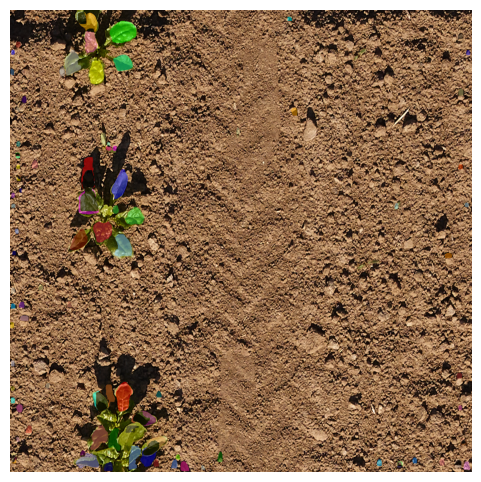

In [29]:
image = read_image("PhenoBench/val/images/05-15_00056_P0030859.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    predictions = model([x.to(device), ])
    pred = predictions[0]

print(pred.keys())
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
masks = (pred["masks"] > 0.8).squeeze(1)
output_image = draw_segmentation_masks(image, masks, alpha=0.5, colors=colors)

plt.figure(figsize=(6, 6))
plt.imshow(output_image.permute(1, 2, 0))

plt.axis("off")
plt.savefig("output_image.png")
plt.show()

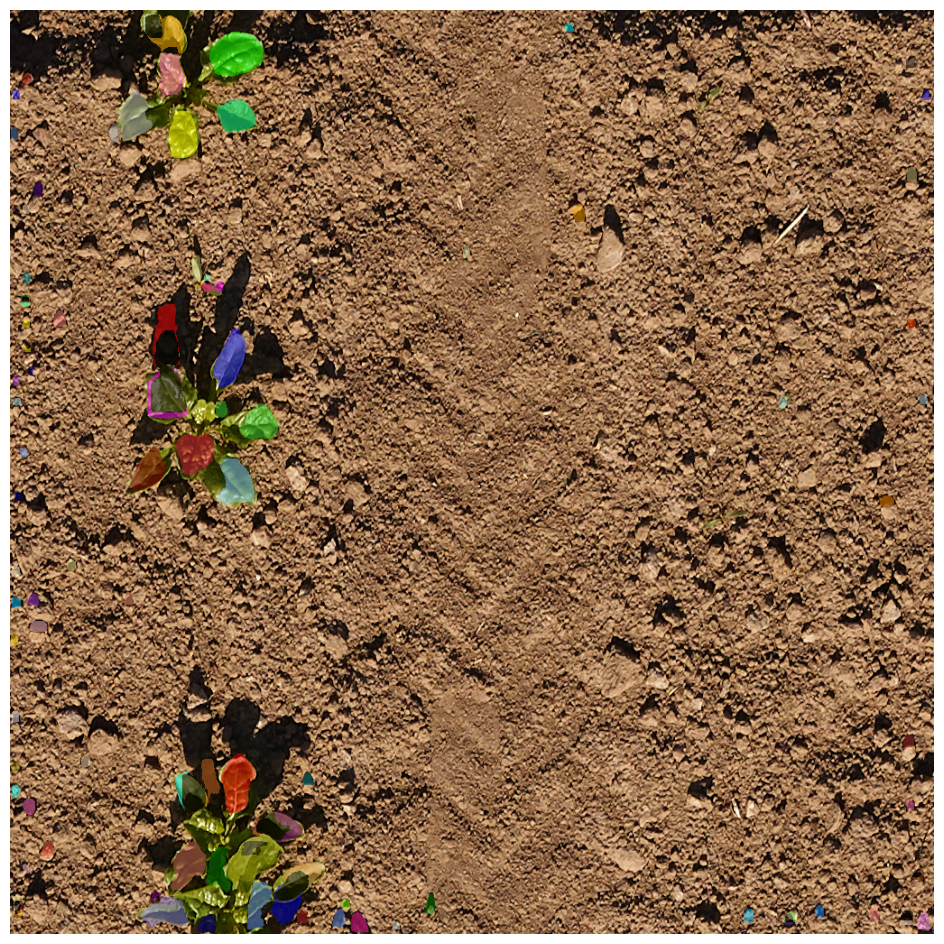

In [30]:
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis("off")
plt.savefig('pred.png')
plt.imshow(output_image.permute(1, 2, 0))
plt.axis("off")
plt.savefig('pred.jpg')
plt.imshow(output_image.permute(1, 2, 0))
plt.axis("off")
plt.savefig('pred.svg')
